In [1]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

# launch stuff inside virtual display here

#vdisplay.stop()

In [2]:
def hex2rgb(hexcolor):
    return [(hexcolor>>16) & 0xff, (hexcolor>>8) & 0xff, hexcolor & 0xff]

def rgb2hex(rgbcolor):
    r, g, b = rgbcolor
    rgb = hex((r << 16) + (g << 8) +b)[2:].upper()
    zero = '0'* (6-len(rgb))
    return '#'+zero+rgb
#----------------------------------
def generateColor(labelL):
    labelL = list(set(labelL))
    labelL.sort()
    colorD = {}
    
    r = 255
    g = 255
    b = 255
    len_label = int(len(labelL) / 3 + 1)
    step = int(250 / len_label)
    
    cnt = 1
    for labels in labelL:
        if cnt % 3 == 1:
            r = r - step 
        elif cnt % 3 == 2:
            g = g -step
        else:
            b = b - step
        cnt += 1
        color = rgb2hex([r, g, b])
        colorD[labels] = color
    return colorD

In [3]:
from ete3 import Tree, faces, TreeStyle, NodeStyle
from ete3 import ClusterTree, RectFace, AttrFace, ProfileFace, TextFace
from ete3.treeview.faces import add_face_to_node
import pandas as pd
import numpy as np
import colorsys

In [23]:
dir = "/MPATHC/ct/nrc/linhuixin/genome_cyp450/cuffmerge/custom_raxmltree_one/mafft_einsi-trimal_gappyout-pmodeltest_full_fast-phyml_default/"
cyp_nw = dir + "Andro.cyp450.expr.fa.final_tree.nw"
cyp_nwx = dir + "Andro.cyp450.expr.fa.final_tree.nwx"
cyp_alg = dir + "Andro.cyp450.expr.fa.final_tree.used_alg.fa"
cyp_mapF = "/home/ct/data/nrc/linhuixin/genome_cyp450/cuffmerge/Andro.cyp450.expr.name_map"
cyp_exprM = "/home/ct/data/nrc/linhuixin/genome_cyp450/cuffmerge/Andro.cyp450.expr.only.xls"

In [10]:
import pandas as pd
mapMatrix = pd.read_table(cyp_mapF, header=0, index_col=0)
mapMatrix.head()

,transcript_id,CYP_clan,CYP_family
ID,,,
XLOC_000181,TCONS_00000522,CYP85,CYP724
XLOC_000372,TCONS_00001057,CYP71,CYP71
XLOC_000373,TCONS_00001058,CYP71,CYP71
XLOC_000375,TCONS_00001060,CYP71,CYP71
XLOC_000376,TCONS_00001062,CYP71,CYP71


In [11]:
CYP_clanD = mapMatrix['CYP_clan'].to_dict()
print CYP_clanD["XLOC_000181"]
CYP_familyD = mapMatrix['CYP_family'].to_dict()
print CYP_familyD["XLOC_000181"]
clan_colorD = generateColor(CYP_clanD.values())
family_colorD = generateColor(CYP_familyD.values())

CYP85
CYP724


In [12]:
cyp_t = Tree(cyp_nw)

In [15]:
cyp_ts = TreeStyle()
cyp_ts.show_leaf_name = False
cyp_ts.show_branch_length = True
cyp_ts.show_branch_support = True

nameFace = faces.AttrFace("name", fsize=12, fgcolor="#FFFFFF")

# Creates my own layout function. I will use all previously created
# faces and will set different node styles depending on the type of
# node.
def mylayout(node):
    # If node is a leaf, add the nodes name and a its scientific
    # name
    if node.is_leaf():
        # Add an static face that handles the node name
        faces.add_face_to_node(nameFace, node, column=0)
        # We can also create faces on the fly
        family = CYP_familyD.get(node.name, node.name)
        familyFace = faces.TextFace(family)
        faces.add_face_to_node(familyFace, node, column=1)
        
        # We can also create faces on the fly
        clan = CYP_clanD.get(node.name, node.name)
        clanFace = faces.TextFace(clan)
        faces.add_face_to_node(clanFace, node, column=1, aligned=True)
        
        # Sets the style of leaf nodes
        node.img_style["size"] = 12
        node.img_style["shape"] = "sphere"
        node.img_style["fgcolor"] = family_colorD.get(family, '#FFFF00')
        node.img_style["vt_line_color"] = family_colorD.get(family, '#FF00FF')
        node.img_style["hz_line_color"] = family_colorD.get(family, '#FF00FF')
        node.img_style["bgcolor"] = clan_colorD.get(clan, '#000000')
    #If node is an internal node
    else:
        # Sets the style of internal nodes
        node.img_style["size"] = 1
        node.img_style["shape"] = "circle"
        node.img_style["fgcolor"] = "darkred"

    # If leaf is "Hsa" (homo sapiens), highlight it using a
    # different background.
    #if node.is_leaf() and node.name.startswith("Hsa"):
        


cyp_ts.layout_fn = mylayout

cyp_t.img_style["size"] = 30
cyp_t.img_style["fgcolor"] = "black"
    
#cyp_t.render(file_name="%%inline", w=1000, tree_style=ts)
a = cyp_t.render(file_name="~/data/nrc/linhuixin/genome_cyp450/cuffmerge/Andro.cyp450.raw.tree.pdf", w=1000, tree_style=cyp_ts)

In [69]:
nameFace = AttrFace("name", fsize=12)

def setup_heatmap(tree, tree_style, header, center_value=0.0, nameMap ={}, nameLabel = '',
                  color_up=0.7, color_down=0.2, color_center="white"):
    DEFAULT_COLOR_SATURATION = 0.3
    BASE_LIGHTNESS = 0.7
    def gradient_color(value, max_value, saturation=0.5, hue=0.1):    
        def rgb2hex(rgb):
            return '#%02x%02x%02x' % rgb
        def hls2hex(h, l, s):
            return rgb2hex( tuple(map(lambda x: int(x*255), 
                                      colorsys.hls_to_rgb(h, l, s))))
    
        lightness = 1 - (value * BASE_LIGHTNESS) / max_value
        return hls2hex(hue, lightness, DEFAULT_COLOR_SATURATION)


    # Calculate max gradient value from the ClusterTree matrix
    maxv = abs(center_value - tree.arraytable._matrix_max)
    minv = abs(center_value - tree.arraytable._matrix_min)
    if center_value <= tree.arraytable._matrix_min:
        MAX_VALUE = minv + maxv
    else:
        MAX_VALUE = max(maxv, minv)
        
    # Add heatmap colors to tree
    cols_add_before_heat = 0
    if nameMap:
        cols_add_before_heat = 1
    for lf in tree:
        if nameMap:
            longNameFace = faces.TextFace(nameMap.get(lf.name, lf.name))
            lf.add_face(longNameFace, column=0, position="aligned")
            
        for i, value in enumerate(getattr(lf, "profile", [])):
            if value > center_value:
                color = gradient_color(abs(center_value - value), MAX_VALUE, 
                                       hue=color_up)
            elif value < center_value:
                color = gradient_color(abs(center_value - value), MAX_VALUE, 
                                       hue=color_down)
            else:
                color = color_center
            lf.add_face(RectFace(20, 20, color, color), position="aligned", 
                        column=i+cols_add_before_heat)
            # Uncomment to add numeric values to the matrix
            #lf.add_face(TextFace("%0.2f "%value, fsize=5), position="aligned", column=i)
        lf.add_face(nameFace, column=i+cols_add_before_heat+1, position="aligned")
        
    if nameMap and nameLabel:
        nameF = TextFace(nameLabel, fsize=7)
        #nameF.rotation = -90
        tree_style.aligned_header.add_face(nameF, column=0)
    # Add header 
    for i, name in enumerate(header):
        nameF = TextFace(name, fsize=7)
        nameF.rotation = -90
        tree_style.aligned_header.add_face(nameF, column=i+cols_add_before_heat)
 #-------------END setup_heatmap----------------------------------------------        



In [60]:
# Creates my own layout function. I will use all previously created
# faces and will set different node styles depending on the type of
# node.
def mylayout_style(node):
    # If node is a leaf, add the nodes name and a its scientific
    # name
    if node.is_leaf():               
        # Sets the style of leaf nodes
        family = CYP_familyD.get(node.name, node.name)
        clan = CYP_clanD.get(node.name, node.name)
        node.img_style["size"] = 12
        node.img_style["shape"] = "sphere"
        node.img_style["fgcolor"] = family_colorD.get(family, '#FFFF00')
        node.img_style["vt_line_color"] = family_colorD.get(family, '#FF00FF')
        node.img_style["hz_line_color"] = family_colorD.get(family, '#FF00FF')
        node.img_style["bgcolor"] = clan_colorD.get(clan, '#000000')
    #If node is an internal node
    else:
        # Sets the style of internal nodes
        node.img_style["size"] = 1
        node.img_style["shape"] = "circle"
        node.img_style["fgcolor"] = "darkred"

In [56]:
data = pd.read_table(cyp_exprM, header=0, index_col=0)
#data.head()
data_log2 = np.log2(data+1)
data_log2.index.name = "#Names"
data_log2.head()

,T0_1,T0_2,T0_3,T2_1,T2_2,T2_3,T4_1,T4_2,T4_3,T12_1,T12_2,T12_3,T24_1,T24_3,T48_1,T48_2,T48_3
#Names,,,,,,,,,,,,,,,,,
XLOC_000181,6.522318,6.860174,5.635004,4.944033,5.167446,5.023473,5.856381,5.293674,5.742954,4.568948,3.476299,5.136950,4.454306,5.322706,4.796281,4.746581,4.453663
XLOC_000372,7.712077,7.954392,7.705713,8.360216,8.810671,8.042795,6.805051,7.021404,6.929281,7.278669,6.824562,6.730494,7.056787,6.660429,7.733707,7.306675,7.273947
XLOC_000373,6.134897,5.939423,6.042765,6.643198,6.909304,6.700181,5.695868,6.653675,6.151241,3.806475,3.215315,4.068532,6.181405,6.544594,6.086714,5.779716,5.784654
XLOC_000375,7.348068,7.657948,7.806781,9.764030,9.315332,9.826336,9.051768,8.979170,9.357965,8.329692,7.770306,8.387913,8.257484,9.043823,8.090174,9.360272,8.720088
XLOC_000376,14.573300,14.513737,14.664626,15.342372,15.305104,15.321604,14.953997,14.775449,15.219061,13.894266,13.706802,14.106592,14.599918,15.177972,14.415250,15.223020,14.897434


In [58]:
data_log2_mat = data_log2.to_csv(None, sep="\t", float_format="%.2f")

In [70]:
cyp_t_expr = ClusterTree(cyp_nw, data_log2_mat)
header = pd.read_table(cyp_exprM,header=0,index_col=0)
header = list(header.columns.values)
cyp_t_expr_ts = TreeStyle()
cyp_t_expr_ts.show_leaf_name = False
cyp_t_expr_ts.show_branch_length = True
cyp_t_expr_ts.show_branch_support = True

In [71]:
cyp_t_expr_ts.layout_fn = mylayout_style

cyp_t_expr.img_style["size"] = 30
cyp_t_expr.img_style["fgcolor"] = "black"

In [72]:
setup_heatmap(cyp_t_expr, cyp_t_expr_ts, header, center_value=0, nameMap=CYP_familyD, 
              nameLabel = "family", color_up=0.9, color_down=0.3, color_center="white")

#cyp_t_expr.render(file_name="%%inline", w=600,tree_style=cyp_t_expr_ts)

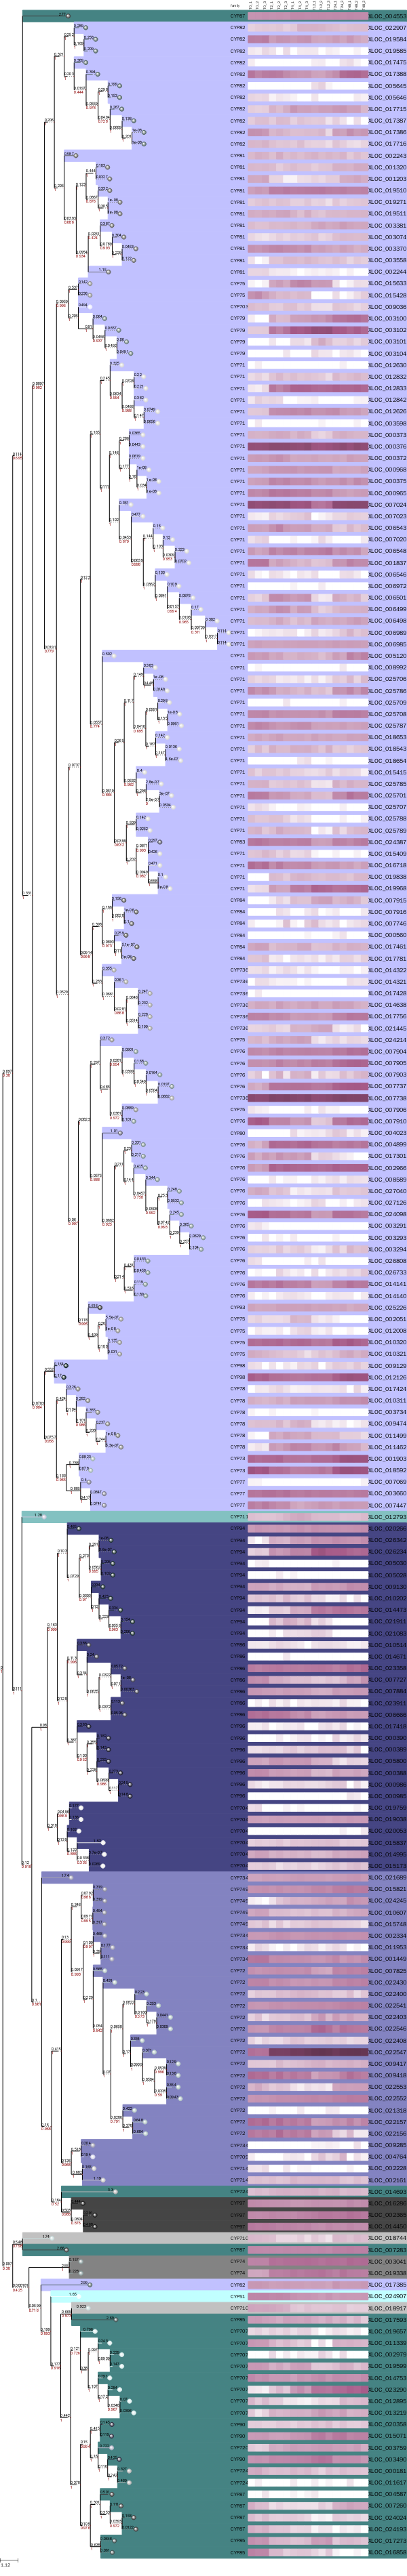

In [74]:
cyp_t_expr.render(file_name="%%inline", w=600,tree_style=cyp_t_expr_ts)

In [75]:
a = cyp_t_expr.render(file_name="/home/ct/data/nrc/linhuixin/genome_cyp450/cuffmerge/Andro.cyp450.raw.tree.expr.pdf", w=500,tree_style=cyp_t_expr_ts)

In [ ]:
# EXAMPLE
        
#matrix = """
##Names\tcol1\tcol2\tcol3\tcol4\tcol5\tcol6\tcol7
#A\t-1.23\t-0.81\t1.79\t0.78\t-0.42\t-0.69\t0.58
#B\t-1.76\t-0.94\t1.16\t0.36\t0.41\t-0.35\t1.12
#C\t-2.19\t0.13\t0.65\t-0.51\t0.52\t1.04\t0.36
#D\t-1.22\t-0.98\t0.79\t-0.76\t-0.29\t1.54\t0.93
#E\t-1.47\t-0.83\t0.85\t0.07\t-0.81\t1.53\t0.65
#F\t-1.04\t-1.11\t0.87\t-0.14\t-0.80\t1.74\t0.48
#G\t-1.57\t-1.17\t1.29\t0.23\t-0.20\t1.17\t0.26
#H\t-1.53\t-1.25\t0.59\t-0.30\t0.32\t1.41\t0.77
#"""

# Load tree
#t = ClusterTree("(((A,B),(C,(D,E))),(F,(G,H)));", text_array=matrix)
#header = "col1 col2 col3 col4 col5 col6 col7".split()
#tree_style = TreeStyle()

# This function adds faces and header labels to any ClusterTree, supporting
# heatmaps of 1 or 2 color series.  If center value is set to the minimum value
# observed in the matrix, only one color will be used used, otherwise values
# above the center will use a custom color gradient, and values bellow a
# different color gradient.  The base color of each gradient is specified with
# color_up and color_down variables, whose value should be between 0 and 1 (hue
# color value, see http://en.wikipedia.org/wiki/HSL_and_HSV)
#setup_heatmap(t, tree_style, header, center_value=0,
#              color_up=0.9, color_down=0.2, color_center="white")

#t.render(file_name="%%inline", tree_style=tree_style)

In [ ]:
vdisplay.stop()